In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))

from google.colab import drive
drive.mount('/content/drive')


%cd /content/drive/My Drive/Colab Notebooks
# RMS prop run again to get less std.

In [0]:
# Importing Libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import argparse

import copy
from model import *
from utils import *
from kfac import *
from kfac_utils import *

In [0]:
validation_losses = []
seeds = [12345, 1234, 123]
for seed in seeds:
    print ("seed:::", seed)
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model Hyperparamters
    batch_size = 64
    epochs = 14
    lrs = [3e-2, 3e-3, 3e-4, 3e-5, 3e-6]  
    gamma = 0.7
    momentum = 0.9
    stat_decay = 0.95
    damping = 1e-3
    kl_clip = 1e-2
    weight_decay = 3e-3
    TCov = 10
    TScal = 10
    TInv = 100      


    use_cuda = torch.cuda.is_available()
    train_loader, val_loader, test_loader, train_size, val_size = dataloaders(batch_size, use_cuda, seed)
    print (train_size, val_size, len(test_loader.dataset))

    model = Net().to(device)
    
    # Grid Search over different learning rates - over validation dataset
    val_losses = []
    for lr in lrs:
        print ("lr:", lr)
        model_copy = copy.deepcopy(model)
        optimizer = KFACOptimizer(model_copy, lr=lr, momentum=momentum,stat_decay=stat_decay,damping=damping,kl_clip=kl_clip,
                            weight_decay=weight_decay,TCov=TCov,TInv=TInv)

        for epoch in range(1, epochs + 1):
            train_loss = train_kfac(model_copy, device, train_loader, optimizer, epoch, batch_size)
            val_loss = test_2(model_copy, device, val_loader, batch_size, val_size)
            # test_loss = test(model_copy, device, test_loader, batch_size)  # one can see on test_loss as well.....
        val_losses.append(val_loss)
    # print ("Validation Losses::\n", val_losses)  
    validation_losses.append(val_losses)  

seed::: 12345
54000 6000 10000
lr: 0.03
Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
)
=> We keep following layers in KFAC. 
(0): Linear(in_features=784, out_features=1024, bias=True)
(1): Linear(in_features=1024, out_features=1024, bias=True)
(2): Linear(in_features=1024, out_features=10, bias=True)

Test set: Average loss: 2.4486, Accuracy: 648/6000 (11%)


Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)


Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)


Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)


Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)


Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)


Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)


Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)


Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)


Test set: Average

In [0]:
print (validation_losses)
validation_losses = np.mean(np.array(validation_losses), 0)
print ("averaged_validation losses::\n", validation_losses)

[[2.3025848789417998, 2.3025848789417998, 2.3025848789417998, 0.10295038765415232, 0.07840909420492802], [2.3025848789417998, 2.3025848789417998, 2.3025848789417998, 0.09333450418520481, 0.07922376632848953], [2.3025848789417998, 2.3025848789417998, 2.3025848789417998, 0.1178667300995043, 0.0777067448547546]]
averaged_validation losses::
 [2.30258488 2.30258488 2.30258488 0.10471721 0.07844654]


'best lr = 3e-6 in case of RMSprop'

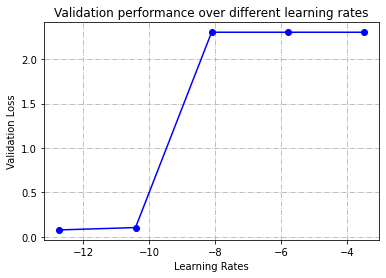

In [0]:
# Learning Rates - ['3e-2', '3e-3', '3e-4', '3e-5', '3e-6'] plotted on log scale
lr_rates = np.log(np.array(lrs))
fig = plt.figure()
plt.plot(lr_rates, validation_losses, color='blue', marker='o') 
plt.xlabel('Learning Rates')
plt.ylabel('Validation Loss')
plt.title("Validation performance over different learning rates")
plt.grid(True, linestyle='-.')
fig.show()   
# plt.legend(['3e-2', '3e-3', '3e-4', '3e-5', '3e-6'], loc='upper right')
"""best lr = 3e-6 in case of NGD"""

In [0]:
avg_train_losses, avg_test_losses, avg_difference_test_train = [], [], []
avg_weight_norms_list, avg_sharpness_list, avg_std_list, avg_mean_list = [], [], [], []


seeds = [12345, 1234, 123]
for seed in seeds:
    print ("seed:::", seed)
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model Hyperparamters
    batch_size = 64
    epochs = 14
    lr = 3e-6 # good one - lowest validation loss among others
    gamma = 0.7
    momentum = 0.9
    stat_decay = 0.95
    damping = 1e-3
    kl_clip = 1e-2
    weight_decay = 3e-3
    TCov = 10
    TScal = 10
    TInv = 100      

    use_cuda = torch.cuda.is_available()
    train_loader, val_loader, test_loader, train_size, val_size = dataloaders(batch_size, use_cuda, seed)
    print (train_size, val_size, len(test_loader.dataset))

    model = Net().to(device)

    train_losses, test_losses = [], []
    sigmas = [0.001,0.003,0.006,0.009,0.03,0.06,0.09]    
    delta = 1e-2
    mean = 0.0
    weight_norms_list = []
    sharpness_list = []

    optimizer = KFACOptimizer(model,lr=lr, momentum=momentum,stat_decay=stat_decay,damping=damping,kl_clip=kl_clip,
                            weight_decay=weight_decay,TCov=TCov,TInv=TInv)

    for epoch in range(1, epochs + 1):
        train_loss = train_kfac(model, device, train_loader, optimizer, epoch, batch_size)
        train_losses.append(train_loss)
        test_loss = test(model, device, test_loader, batch_size)
        test_losses.append(test_loss)
        # scheduler.step()
    
    avg_train_losses.append(train_losses) 
    avg_test_losses.append(test_losses)

    # print train and test losses and their difference
    difference_test_train = np.array(test_losses)  - np.array(train_losses)
    avg_difference_test_train.append(difference_test_train)

    print ("running for sigmas")
    """run for each sigma"""
    std_list = []
    mean_list = []

    for sigma in sigmas:
        weight_l2_norm = cal_l2_norm(model)
        weight_bound = compute_bound(model, train_size, sigma, weight_l2_norm, delta)  
        weight_norms_list.append(weight_bound)
        # print ("norm bound:::", weight_bound)

        #to calculate sharpness, perturb the same model 10 times, then get expected value
        num_times = 20
        p_train_losses = []
        for iterate in range(num_times):
            p_model = copy.deepcopy(model)
            p_model = weight_pertubation(p_model, mean, sigma, device)
            p_train_loss = test_2(p_model, device, train_loader, batch_size, train_size)
            p_train_losses.append(p_train_loss)
        exp_p_error = sum(p_train_losses) / len(p_train_losses)
        std_list.append(np.std(np.array(p_train_losses)))
        mean_list.append(np.mean(np.array(p_train_losses)))

        sharpness = exp_p_error - train_loss
        sharpness_list.append(sharpness)
    
    avg_weight_norms_list.append(weight_norms_list)
    avg_sharpness_list.append(sharpness_list)
    avg_std_list.append(std_list)
    avg_mean_list.append(mean_list)

seed::: 12345
54000 6000 10000
Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
)
=> We keep following layers in KFAC. 
(0): Linear(in_features=784, out_features=1024, bias=True)
(1): Linear(in_features=1024, out_features=1024, bias=True)
(2): Linear(in_features=1024, out_features=10, bias=True)

Test set: Average loss: 2.2651, Accuracy: 2740/10000 (27%)


Test set: Average loss: 1.5316, Accuracy: 8109/10000 (81%)


Test set: Average loss: 0.5164, Accuracy: 9357/10000 (94%)


Test set: Average loss: 0.3194, Accuracy: 9499/10000 (95%)


Test set: Average loss: 0.2367, Accuracy: 9575/10000 (96%)


Test set: Average loss: 0.1873, Accuracy: 9636/10000 (96%)


Test set: Average loss: 0.1564, Accuracy: 9691/10000 (97%)


Test set: Average loss: 0.1352, Accuracy: 9720/10000 (97%)


Test set: Average loss: 0.1178, Accuracy: 9743/10000 (97%)


Test set

In [0]:
print ("avg_train_losses::\n", avg_train_losses)
print ("avg_test_losses::\n", avg_test_losses)
print ("avg_difference_test_train::\n", avg_difference_test_train)
print ("avg_weight_norms_list::\n", avg_weight_norms_list)
print ("avg_sharpness_list::\n", avg_sharpness_list)
print ("avg_std_list::\n", avg_std_list)

avg_train_losses::
 [[2.293616466330126, 2.0138070885604025, 0.8729676952788615, 0.41131979703761956, 0.2784168365724844, 0.20988390654749214, 0.1665847938754971, 0.13673145617071486, 0.11442732469783434, 0.09719065063460884, 0.08387153894503675, 0.07297755841836687, 0.0638740456605692, 0.05613360314969838], [2.2886222914496868, 1.9763635028312556, 0.8752517762695443, 0.4233797841939316, 0.2827155371218637, 0.2106445329837607, 0.16606372808463765, 0.13600428529101385, 0.1136486171502002, 0.09693681668507827, 0.08362934141644934, 0.07275979679907668, 0.06383289959528858, 0.056240220487965224], [2.288203093960387, 1.9857275323562713, 0.8883153182494132, 0.42658727845591954, 0.2862797016675156, 0.21400330198037115, 0.16969134599429453, 0.13886096543010096, 0.1162990156331616, 0.09914409073943634, 0.08549419562751648, 0.0738882009575576, 0.0643265473135522, 0.05649815416360777]]
avg_test_losses::
 [[2.265145122625266, 1.5315834952008194, 0.516418752966413, 0.3194476107882846, 0.23674842582

In [0]:
# Average over 3 random seeds
avg_train_losses = np.mean(np.array(avg_train_losses), 0)
avg_test_losses = np.mean(np.array(avg_test_losses), 0)
avg_difference_test_train = np.mean(np.array(avg_difference_test_train), 0)

avg_weight_norms_list = np.mean(np.array(avg_weight_norms_list), 0)
avg_sharpness_list = np.mean(np.array(avg_sharpness_list), 0)
avg_std_list = np.mean(np.array(avg_std_list), 0)
avg_mean_list = np.mean(np.array(avg_mean_list), 0)


print ("avg_train_losses:::\n", avg_train_losses)
print ("avg_test_losses:::\n", avg_test_losses)
print ("average difference list::\n", avg_difference_test_train)
print ("avg_weight_norms_list::\n", avg_weight_norms_list)
print ("avg_sharpness_list::\n", avg_sharpness_list)
print ("avg_std_list::\n", avg_std_list)
print ("avg_mean_list::\n", avg_mean_list)


avg_train_losses:::
 [2.29014728 1.99196604 0.87884493 0.42042895 0.28247069 0.21151058
 0.16744662 0.1371989  0.11479165 0.09775719 0.08433169 0.07320852
 0.06401116 0.05629066]
avg_test_losses:::
 [2.25112693 1.46059108 0.52749729 0.32564631 0.2394176  0.18915395
 0.15707787 0.13461054 0.11789025 0.10579099 0.09589934 0.08781198
 0.08148208 0.07618457]
average difference list::
 [-0.03902036 -0.53137496 -0.35134764 -0.09478264 -0.04305309 -0.02235663
 -0.01036875 -0.00258836  0.0030986   0.0080338   0.01156765  0.01460346
  0.01747092  0.01989391]
avg_weight_norms_list::
 [333.84504191 111.28169759  55.64088058  37.09395472  11.128383
   5.56451527   3.71003596]
avg_sharpness_list::
 [-5.17195232e-03 -2.98510247e-03  3.86060419e-03  1.50587395e-02
  5.98018283e-01  6.17766726e+00  1.74184620e+01]
avg_std_list::
 [4.96347921e-05 1.68998764e-04 8.25011522e-04 1.57179154e-03
 1.29340760e-01 1.31064615e+00 3.13283691e+00]
avg_mean_list::
 [ 0.05111871  0.05330556  0.06015126  0.0713494  

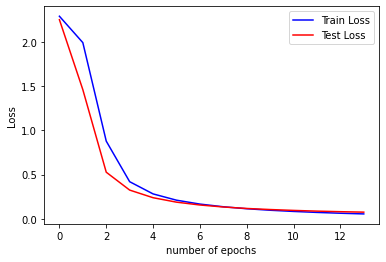

In [0]:
show_losses(avg_train_losses, avg_test_losses)

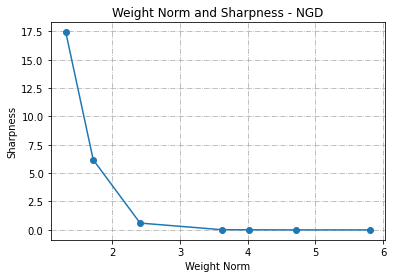

In [0]:
plt.plot(np.log(avg_weight_norms_list), avg_sharpness_list, marker='o')
plt.grid(True, linestyle='-.')
plt.title("Weight Norm and Sharpness - NGD")
plt.xlabel("Weight Norm")
plt.ylabel("Sharpness")
plt.show()
# plt.legend() #loc='lower left'

In [0]:
print (train_losses)

[2.1163159096128004, 0.3691678487814928, 0.06829075171431236, 0.026734713976982082, 0.015211458048690552, 0.01268925697275689, 0.011409533685691196, 0.016703215771977087, 0.011761619426945657, 0.014741226857096636, 0.01238554253980023, 0.011729503646316404, 0.011061688999852864, 0.007981451490057535, 0.008939192874629659, 0.015514482640864337, 0.010903348609239858, 0.011422302856405765, 0.004283629952236388, 0.00880858252239877, 0.006632027507569835, 0.009127929578292497]


In [0]:
print (avg_train_losses)

[2.12366819 0.37398934 0.06662568 0.02604144 0.0156139  0.01222103
 0.01059693 0.0157978  0.01131742 0.01750394 0.01433845 0.01082505
 0.01086576 0.00982891 0.00929895 0.0099873  0.00731231 0.0092401
 0.00432785 0.00880843 0.00756168 0.00966355]
